In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [3]:
df = pd.read_csv('./preprocessed_df.csv') # Has "Unnammed: 0" column"
df = df.drop('Unnamed: 0', axis=1) # dropping the column
df.head()

,subject,label,contractions missing apostrophe,url counts,quote pairs,cleaned text,sentiment,flesch_reading_ease
0,News,1,1,0,0,donald trump wish american happy new year leav...,0.9678,43.69
1,News,1,1,0,0,house intelligence committee chairman devin nu...,0.6300,18.42
2,News,1,1,1,0,friday revealed former milwaukee sheriff david...,-0.9933,44.00
3,News,1,1,4,0,christmas day donald trump announced would bac...,0.1316,33.92
4,News,1,0,0,0,pope francis used annual christmas day message...,0.9105,43.29


In [4]:
df.shape

(44182, 8)

In [5]:
# Identify duplicate cleaned text values
duplicate_texts = df[df.duplicated("cleaned text", keep=False)]

# Display the duplicate rows
print(duplicate_texts)

         subject  label  contractions missing apostrophe  url counts  \
9087    politics      1                                1           3   
9088    politics      1                                1           0   
9089    politics      1                                1           2   
9091    politics      1                                1           0   
9093    politics      1                                0           2   
...          ...    ...                              ...         ...   
44110  worldnews      0                                0           0   
44118  worldnews      0                                0           0   
44171  worldnews      0                                0           0   
44173  worldnews      0                                0           0   
44177  worldnews      0                                0           0   

       quote pairs                                       cleaned text  \
9087             0  barbra streisand obama sycophant one corru

In [6]:
df_unique = df.drop_duplicates("cleaned text", keep="first")
df_unique.shape

(38457, 8)

In [7]:
X = df_unique.drop(['label', 'subject'], axis=1) # Features (IV) ***FOUND SUBJECT TO BE A PROBLEM (100% ACCURACY) -> REMOVE***
y = df_unique['label'] # Target variable (DV)

# Split the data into testing set and temporary set (to be split into training and validation)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 20% of the data will be used for testing

# Split the temporary set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp) # 16% for validation, 64% for training

In [8]:
# Independent variables (IVs) - all columns except "cleaned text" and "subject"
ivs = [col for col in X.columns if col not in ["cleaned text", "subject"]]

print(f"Text column: 'cleaned text'")
print(f"Independent variables (IVs): {ivs}")

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(
            min_df=10,
            max_df=0.9,
            max_features=100,
            ngram_range=(2, 2),
            token_pattern=r'\b[a-zA-Z]{3,}\b'
        ), 'cleaned text'),
        ('ivs', StandardScaler(), ivs)
    ],
    remainder='drop'
)

Text column: 'cleaned text'
Independent variables (IVs): ['contractions missing apostrophe', 'url counts', 'quote pairs', 'sentiment', 'flesch_reading_ease']


In [9]:
# Pipeline w/ preprocessing and logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

In [10]:
# Hyperparameters for grid search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2'],  
    'classifier__solver': ['liblinear', 'saga']  # Solvers compatible with L2
}

# Grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

In [11]:
# Fitting the model on the training data
print("\nTraining the model with grid search...")
grid_search.fit(X_train, y_train)


Training the model with grid search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         TfidfVectorizer(max_df=0.9,
                                                                                         max_features=100,
                                                                                         min_df=10,
                                                                                         ngram_range=(2,
                                                                                                      2),
                                                                                         token_pattern='\\b[a-zA-Z]{3,}\\b'),
                                                                         'cleaned '
                                                                         'text'),
                                                                        ('ivs',
                                                                         StandardScaler(),
                                                                         ['contractions '
                                                                          'missing '
                                                                          'apostrophe',
                                                                          'url '
                                                                          'counts',
                                                                          'quote '
                                                                          'pairs',
                                                                          'sentiment',
                                                                          'flesch_reading_ease'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='f1', verbose=1)

In [12]:
# Print the best parameters
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_


Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.9290477759862352


In [13]:
# Evaluate on validation set
y_val_pred = best_model.predict(X_val)
y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print("\n--- Validation Set Performance ---")
print("Validation Accuracy:", val_accuracy)
print("Validation F1 Score:", val_f1)
print("\nValidation Classification Report:")
print(val_report)


--- Validation Set Performance ---
Validation Accuracy: 0.936941329432797
Validation F1 Score: 0.9302659956865564

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3370
           1       0.93      0.93      0.93      2783

    accuracy                           0.94      6153
   macro avg       0.94      0.94      0.94      6153
weighted avg       0.94      0.94      0.94      6153



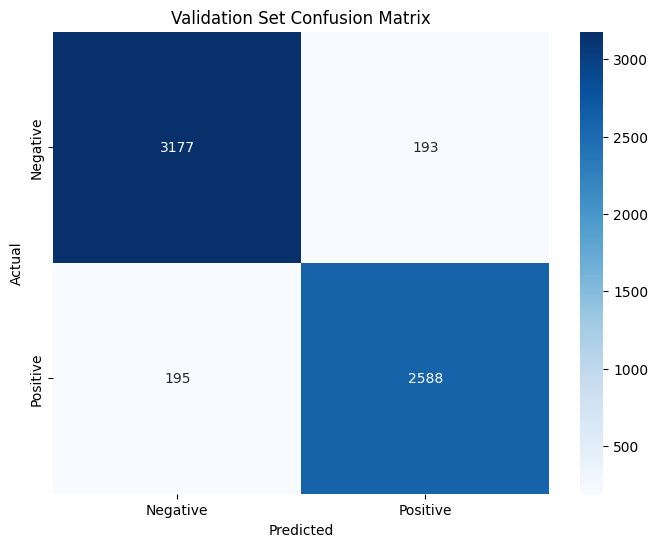

In [14]:
# Plot validation confusion matrix
val_conf_matrix = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()

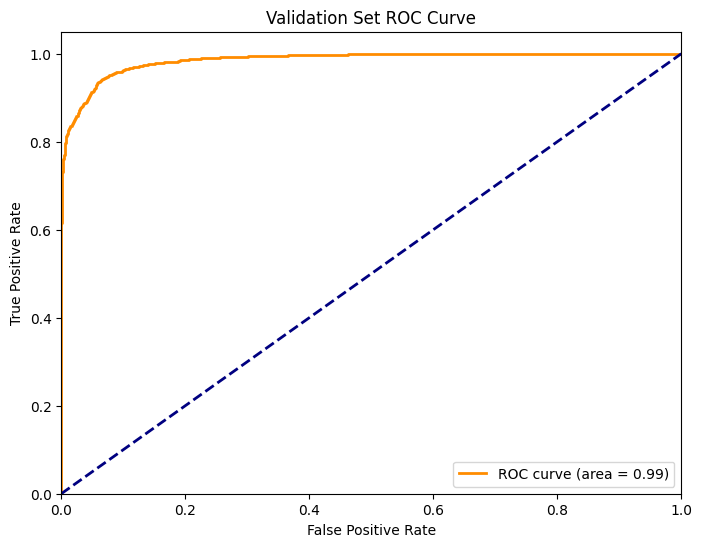

In [15]:
# Plot validation ROC curve
val_fpr, val_tpr, _ = roc_curve(y_val, y_val_pred_proba)
val_roc_auc = auc(val_fpr, val_tpr)

plt.figure(figsize=(8, 6))
plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {val_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Validation Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [16]:
# Final evaluation on test set
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("\n--- Test Set Performance ---")
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("\nTest Classification Report:")
print(test_report)


--- Test Set Performance ---
Test Accuracy: 0.9333073322932918
Test F1 Score: 0.9265989411933038

Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      4213
           1       0.92      0.93      0.93      3479

    accuracy                           0.93      7692
   macro avg       0.93      0.93      0.93      7692
weighted avg       0.93      0.93      0.93      7692



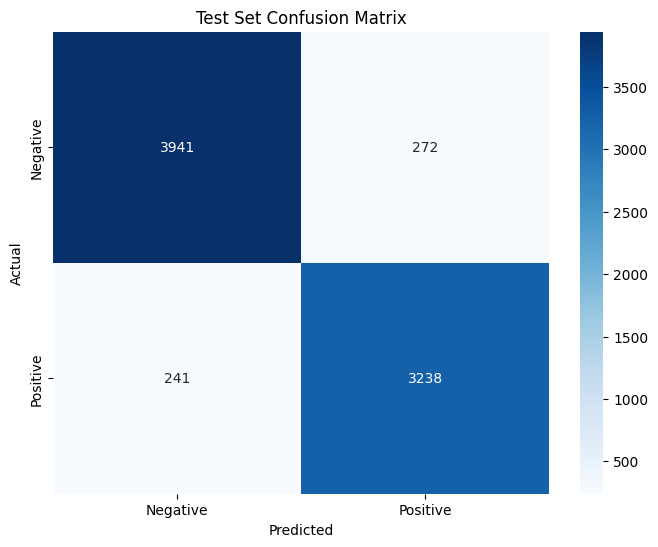

In [17]:
# Plot test confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
plt.show()

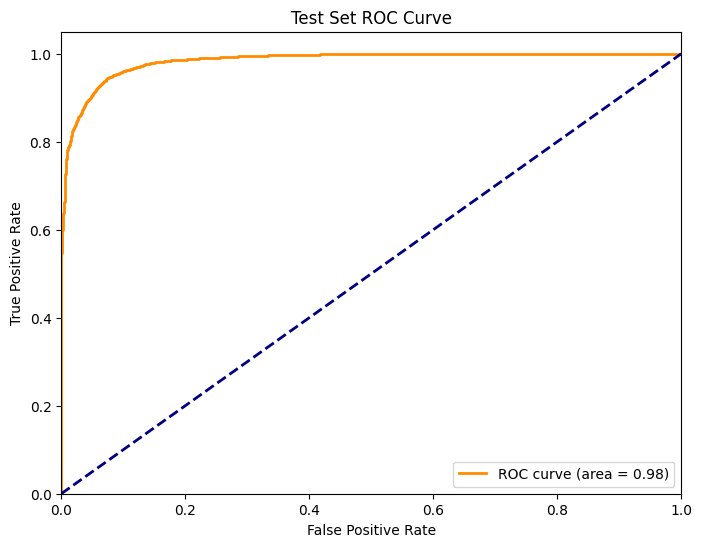

In [18]:
# Plot test ROC curve
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)
test_roc_auc = auc(test_fpr, test_tpr)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'ROC curve (area = {test_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc="lower right")
plt.show()

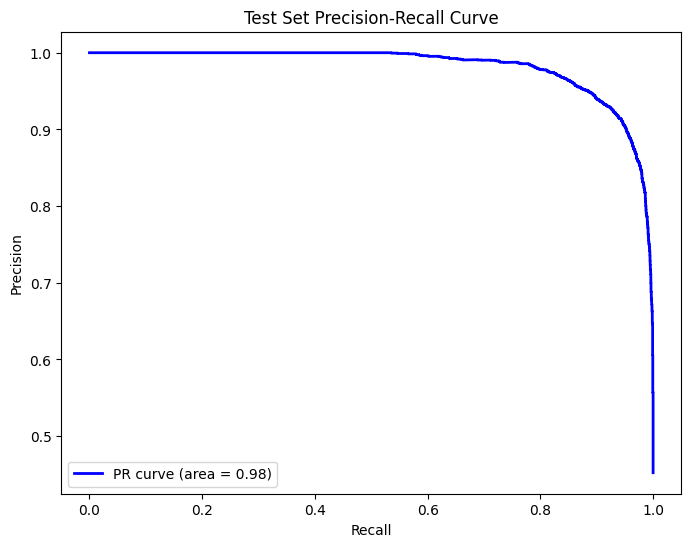

In [19]:
# Plot Precision-Recall curve for test set
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)
test_pr_auc = auc(test_recall, test_precision)

plt.figure(figsize=(8, 6))
plt.plot(test_recall, test_precision, color='blue', lw=2, label=f'PR curve (area = {test_pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Test Set Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [20]:
# Compare validation and test performance
metrics_comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1 Score', 'ROC AUC'],
    'Validation Set': [val_accuracy, val_f1, val_roc_auc],
    'Test Set': [test_accuracy, test_f1, test_roc_auc]
})

print("\n--- Performance Comparison ---")
print(metrics_comparison)


--- Performance Comparison ---
     Metric  Validation Set  Test Set
0  Accuracy        0.936941  0.933307
1  F1 Score        0.930266  0.926599
2   ROC AUC        0.985434  0.984119


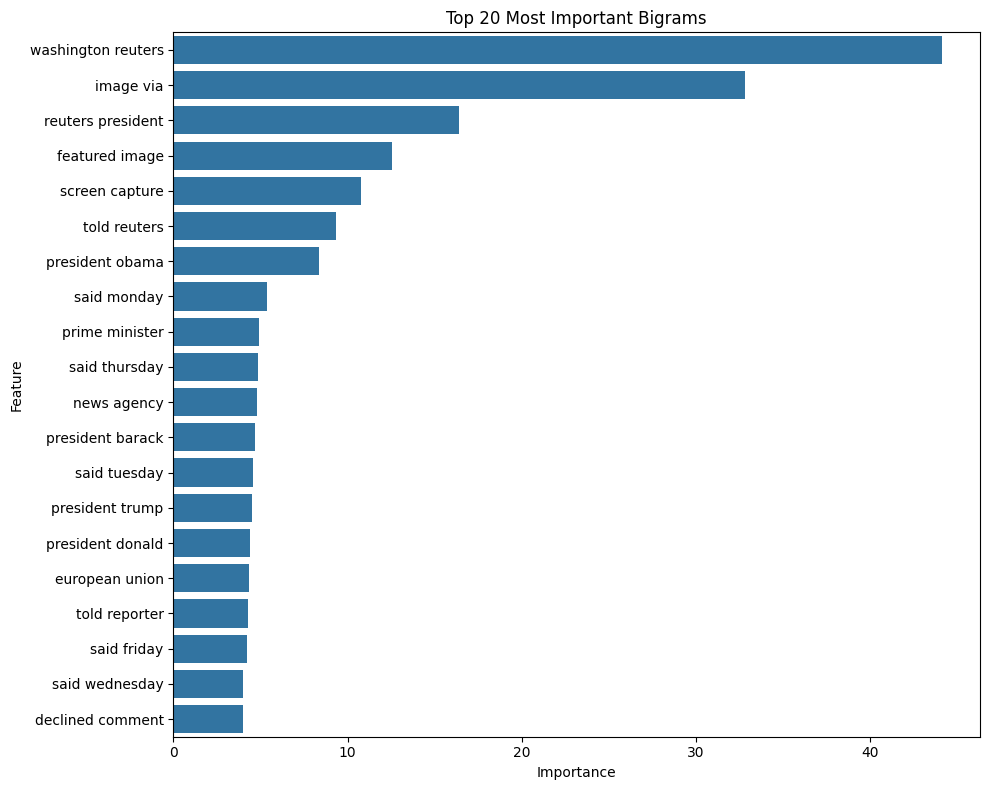

In [21]:
# Feature importance analysis (for the text features)
if hasattr(best_model.named_steps['classifier'], 'coef_'):
    # Get feature names from the TF-IDF vectorizer
    feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    
    # Get coefficients from the logistic regression model
    coefficients = best_model.named_steps['classifier'].coef_[0]
    
    # Create a DataFrame to display feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients[:len(feature_names)])
    })
    
    # Sort by importance and display the top 20 features
    top_features = feature_importance.sort_values('Importance', ascending=False).head(20)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Top 20 Most Important Bigrams')
    plt.tight_layout()
    plt.show()